In [1]:
%load_ext autoreload
%autoreload 2

In [14]:

import keras
import tensorflow as tf
import numpy as np

from jiwer import wer

import matplotlib.pyplot as plt

from consonance.ml_logic.omr import build_model, ctc_decode, decode_batch_predictions, decode_labels, int_to_label, train_dataset, validation_dataset

In [3]:
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 350, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 350, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 175, 25,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 175, 25,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 87, 12,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 87, 768)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 87, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 87, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 87, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 87, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 87, 86)    │     11,094 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 87, 86)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 441,110 (1.68 MB)

 Trainable params: 441,110 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 148s 259ms/step - loss: 2099.1436 - val_loss: 1729.4454
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 162s 288ms/step - loss: 1736.9801 - val_loss: 1684.8752
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 163s 290ms/step - loss: 1682.3304 - val_loss: 1609.4923
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 167s 297ms/step - loss: 1629.5898 - val_loss: 1590.0023
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 163s 290ms/step - loss: 1609.7791 - val_loss: 1562.7220
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 162s 288ms/step - loss: 1593.3545 - val_loss: 1568.5511
Epoch 7/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 167s 296ms/step - loss: 1576.6323 - val_loss: 1568.6106
Epoch 8/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 164s 291ms/step - loss: 1560.1138 - val_loss: 1510.5205
Epoch 9/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 164s 290ms/step - loss: 1542.1239 - val_loss: 1504.8989
Epoch 10/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 157s 280ms/step - loss: 1520.4473 - val_loss: 1485.0483
Epoch 11/100
563/563 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


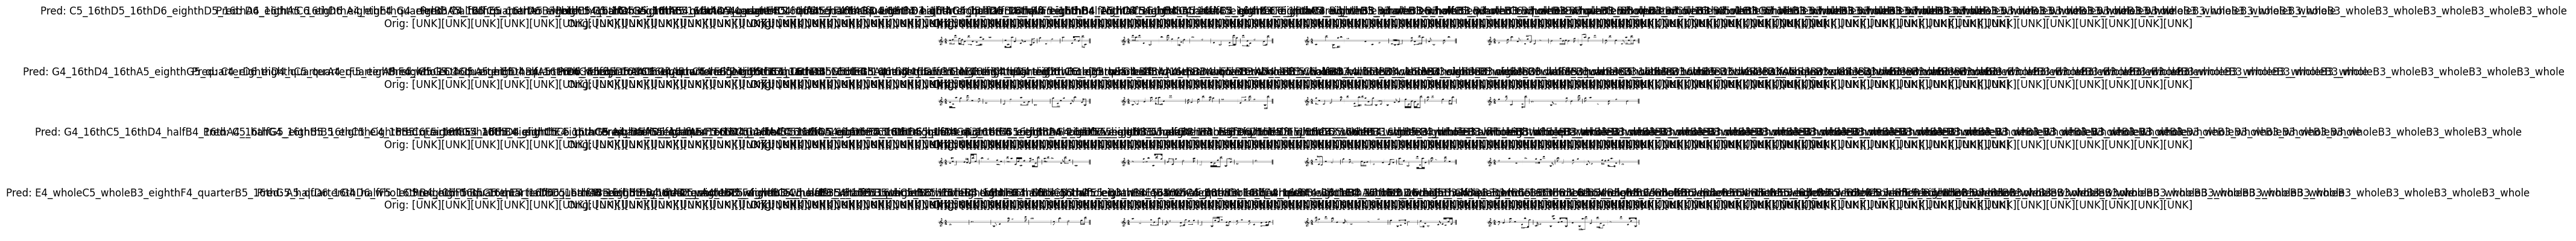

In [43]:
# Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        decoded_label = decode_labels([label.numpy()])[0]
        orig_text = ''.join([int_to_label.get(lbl, '[UNK]') for lbl in decoded_label])
        orig_texts.append(orig_text)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(min(len(pred_texts), 16)):  # Limit to 16 images for display
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Pred: {pred_texts[i]} \nOrig: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()


In [44]:
combined_dict = {
    'B3_whole': 0, 'C4_whole': 1, 'D4_whole': 2, 'E4_whole': 3, 'F4_whole': 4, 'G4_whole': 5, 'A4_whole': 6, 'B4_whole': 7, 'C5_whole': 8,
    'D5_whole': 9, 'E5_whole': 10, 'F5_whole': 11, 'G5_whole': 12, 'A5_whole': 13, 'B5_whole': 14, 'C6_whole': 15, 'D6_whole': 16,

    'B3_half': 17, 'C4_half': 18, 'D4_half': 19, 'E4_half':20, 'F4_half': 21, 'G4_half': 22, 'A4_half': 23, 'B4_half': 24, 'C5_half': 25,
    'D5_half': 26, 'E5_half': 27, 'F5_half': 28, 'G5_half': 29, 'A5_half': 30, 'B5_half': 31, 'C6_half': 32, 'D6_half': 33,

    'B3_quarter': 34, 'C4_quarter': 35, 'D4_quarter': 36, 'E4_quarter': 37, 'F4_quarter': 38, 'G4_quarter': 39, 'A4_quarter': 40, 'B4_quarter': 41, 'C5_quarter': 42,
    'D5_quarter': 43, 'E5_quarter': 44, 'F5_quarter': 45, 'G5_quarter': 46, 'A5_quarter': 47, 'B5_quarter': 48, 'C6_quarter': 49, 'D6_quarter': 50,

    'B3_eighth': 51, 'C4_eighth': 52, 'D4_eighth': 53, 'E4_eighth': 54, 'F4_eighth': 55, 'G4_eighth': 56, 'A4_eighth': 57, 'B4_eighth': 58, 'C5_eighth': 59,
    'D5_eighth': 60, 'E5_eighth': 61, 'F5_eighth': 62, 'G5_eighth': 63, 'A5_eighth': 64, 'B5_eighth': 65, 'C6_eighth': 66, 'D6_eighth': 67,

    'B3_16th': 68, 'C4_16th': 69, 'D4_16th': 70, 'E4_16th': 71, 'F4_16th': 72, 'G4_16th': 73, 'A4_16th': 74, 'B4_16th': 75, 'C5_16th': 76,
    'D5_16th': 77, 'E5_16th': 78, 'F5_16th': 79, 'G5_16th': 80, 'A5_16th': 81, 'B5_16th': 82, 'C6_16th': 83, 'D6_16th': 84
}

In [48]:
import re

# Function to split combined labels like "F4_halfG4_eighth" into "F4_half G4_eighth"
def split_labels(label):
    return ' '.join(re.findall(r'[A-G][b#]?\d+_\w+', label))

# Apply this function to both targets and predictions for readability
split_targets = [split_labels(label) for label in targets]
split_predictions = [split_labels(pred) for pred in predictions]


In [45]:
from jiwer import wer

# Convert numeric sequences back to their corresponding characters
def num_to_char(label):
    return ''.join([int_to_label.get(int(lbl), '[UNK]') for lbl in label])

predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch['image'], batch['label']
    batch_predictions = prediction_model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)

    for label in y:
        label = tf.strings.reduce_join([int_to_label.get(int(lbl), '[UNK]') for lbl in label]).numpy().decode("utf-8")
        label = label.strip('[UNK]').strip('*')
        targets.append(label)

# Function to split combined labels like "F4_halfG4_eighth" into "F4_half G4_eighth"
def split_labels(label):
    return ' '.join(re.findall(r'[A-G][b#]?\d+_\w+', label))

# Apply this function to both targets and predictions for readability
split_targets = [split_labels(label) for label in targets]
split_predictions = [split_labels(pred) for pred in predictions]

# Calculate Word Error Rate (WER)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

# Display some random samples of predictions and targets
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

In [46]:
def character_level_accuracy(targets, predictions):
    total_chars = sum([len(target) for target in targets])
    correct_chars = sum([sum([1 for t, p in zip(target, pred) if t == p])
                         for target, pred in zip(targets, predictions)])
    return correct_chars / total_chars

char_accuracy = character_level_accuracy(targets, predictions)
print(f"Character-Level Accuracy: {char_accuracy:.4f}")


Character-Level Accuracy: 0.5868


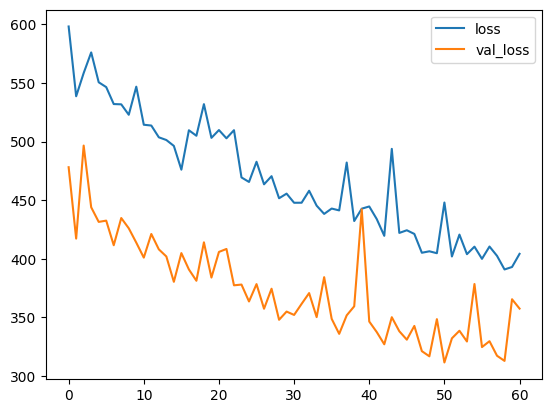

In [47]:
l = history.history
l, vl = l['loss'], l['val_loss']
plt.plot(l, label='loss')
plt.plot(vl, label='val_loss')
plt.legend()

In [49]:
model.save("../data/training_dual_model_1k.keras")
prediction_model.save("../data/predict_dual_1k.keras")

Number of images found:  10000
Number of labels found:  10000
Number of unique characters (label values):  85
Unique label values (characters):  ['A4_16th', 'A4_eighth', 'A4_half', 'A4_quarter', 'A4_whole', 'A5_16th', 'A5_eighth', 'A5_half', 'A5_quarter', 'A5_whole', 'B3_16th', 'B3_eighth', 'B3_half', 'B3_quarter', 'B3_whole', 'B4_16th', 'B4_eighth', 'B4_half', 'B4_quarter', 'B4_whole', 'B5_16th', 'B5_eighth', 'B5_half', 'B5_quarter', 'B5_whole', 'C4_16th', 'C4_eighth', 'C4_half', 'C4_quarter', 'C4_whole', 'C5_16th', 'C5_eighth', 'C5_half', 'C5_quarter', 'C5_whole', 'C6_16th', 'C6_eighth', 'C6_half', 'C6_quarter', 'C6_whole', 'D4_16th', 'D4_eighth', 'D4_half', 'D4_quarter', 'D4_whole', 'D5_16th', 'D5_eighth', 'D5_half', 'D5_quarter', 'D5_whole', 'D6_16th', 'D6_eighth', 'D6_half', 'D6_quarter', 'D6_whole', 'E4_16th', 'E4_eighth', 'E4_half', 'E4_quarter', 'E4_whole', 'E5_16th', 'E5_eighth', 'E5_half', 'E5_quarter', 'E5_whole', 'F4_16th', 'F4_eighth', 'F4_half', 'F4_quarter', 'F4_whole', 

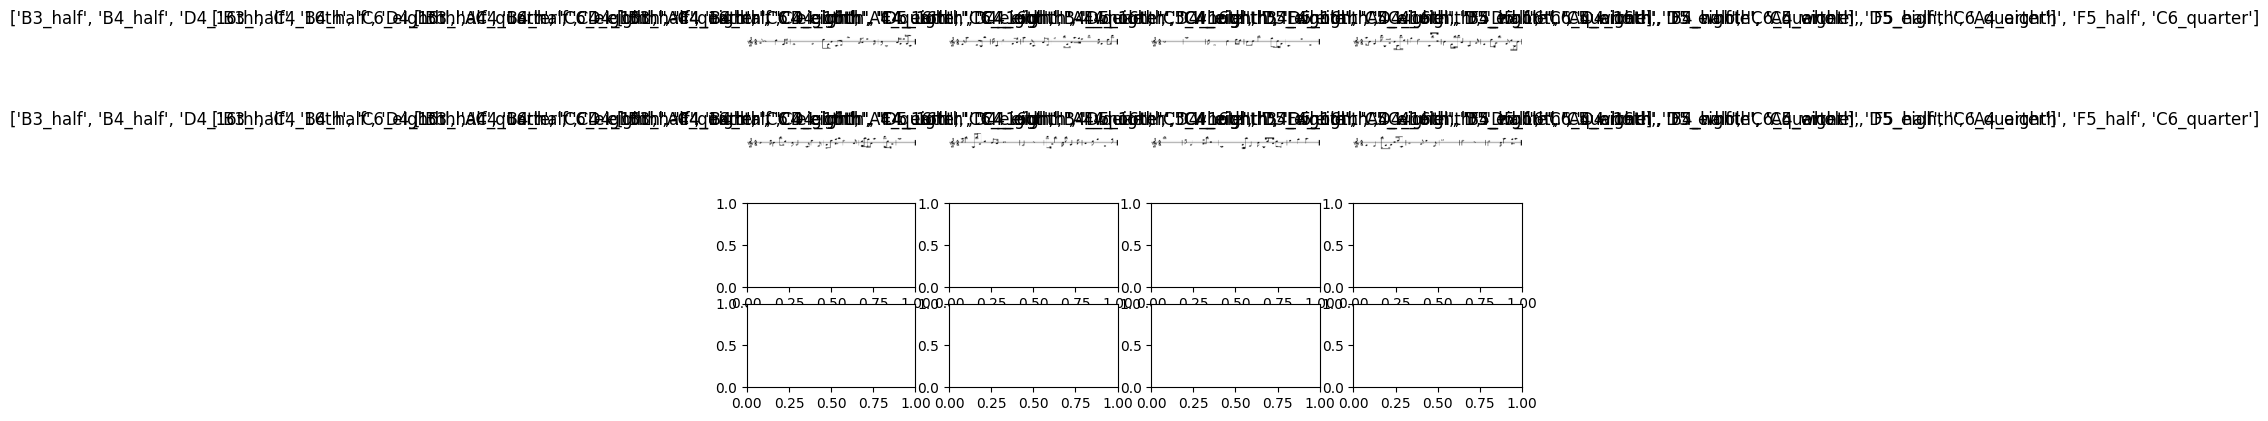

Epoch 1/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 937.1199
Epoch 1: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 156s 276ms/step - loss: 937.1071 - val_loss: 837.1733
Epoch 2/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 926.0505
Epoch 2: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 148s 263ms/step - loss: 926.0522 - val_loss: 835.5999
Epoch 3/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 935.2629
Epoch 3: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 148s 262ms/step - loss: 935.2387 - val_loss: 816.4780
Epoch 4/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 917.0777
Epoch 4: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 146s 260ms/step - loss: 917.0576 - val_loss: 821.8531
Epoch 5/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 903.8578
Epoch 5: sav

KeyboardInterrupt: 

In [40]:
# Resume training, set up checkpoints

from keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    '../data/model_checkpoints/model_checkpoint.keras',   # Filepath to save the model
    monitor='val_loss',      # Monitor validation loss
    save_best_only=False,    # Save the model after every epoch
    save_weights_only=False, # Save the entire model, not just the weights
    verbose=1                # Print a message when saving the model
)

model = keras.models.load_model('../data/training_dual_model1.keras')
# Train the model with checkpointing

additional_epochs = 900

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=additional_epochs,
    callbacks=[early_stopping, checkpoint_callback],
)


In [41]:
# Resume training, set up checkpoints
checkpoint_callback = ModelCheckpoint(
    '../data/model_checkpoints/model_checkpoint.keras',   # Filepath to save the model
    monitor='val_loss',      # Monitor validation loss
    save_best_only=False,    # Save the model after every epoch
    save_weights_only=False, # Save the entire model, not just the weights
    verbose=1                # Print a message when saving the model
)

model = keras.models.load_model('../data/model_checkpoints/model_checkpoint.keras')
# Train the model with checkpointing

early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

additional_epochs = 900

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=additional_epochs,
    callbacks=[early_stopping, checkpoint_callback],
)


Epoch 1/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 588.5265
Epoch 1: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 143s 251ms/step - loss: 588.5435 - val_loss: 478.0826
Epoch 2/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 552.9307
Epoch 2: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 145s 258ms/step - loss: 552.9053 - val_loss: 417.2036
Epoch 3/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 533.0451
Epoch 3: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 145s 257ms/step - loss: 533.0900 - val_loss: 496.5374
Epoch 4/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 596.0151
Epoch 4: saving model to ../data/model_checkpoints/model_checkpoint.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 150s 266ms/step - loss: 595.9795 - val_loss: 443.9289
Epoch 5/900
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 571.7637
Epoch 5: sav